Status Solusi: Optimal

Solusi Optimal Ditemukan:
  Frekuensi Perawatan Rutin P1 (x1): 10 kali per tahun
  Frekuensi Perawatan Menengah P6 (x2): 2 kali per tahun
  Frekuensi Perawatan Overhaul  P12 (x3): 1 kali per tahun

Total Biaya Minimum: Rp 500,166,055

Pemanfaatan Kendala:
  Waktu Terpakai: 80 jam
  Jumlah Sarana Terpakai: 13 unit


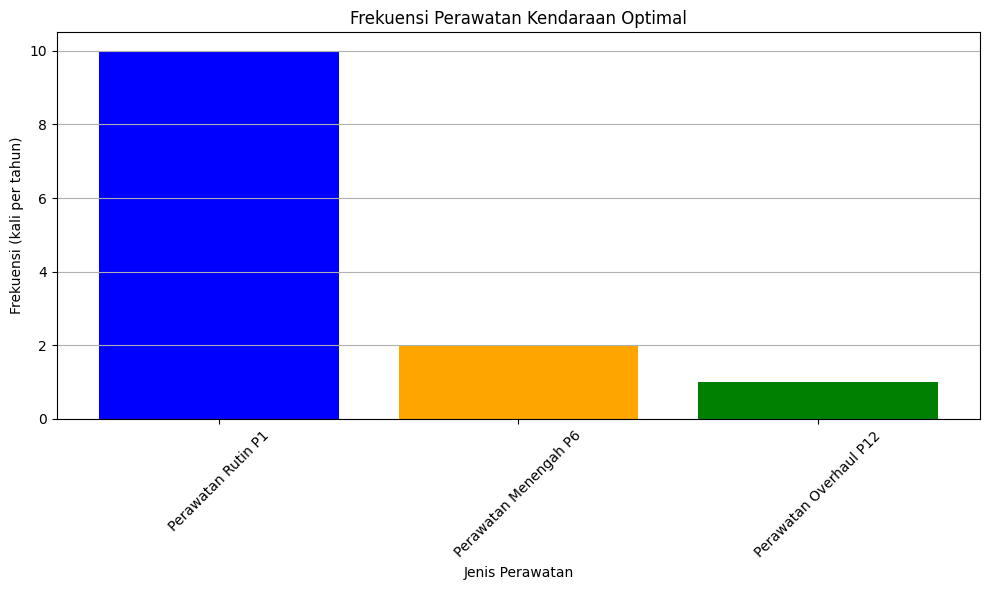

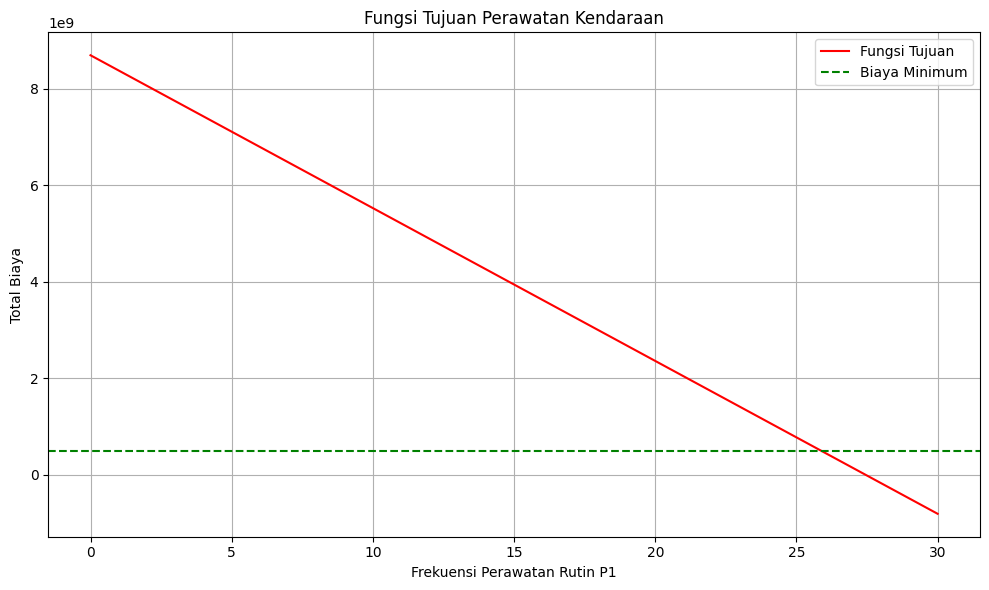

In [5]:
from pulp import *

# 1. Definisikan masalah
prob = LpProblem("Perawatan Kendaraan", LpMinimize)

# 2. Definisikan variabel keputusan
x1 = LpVariable("x1_PerawatanRutinP1", lowBound=0, cat='Integer')
x2 = LpVariable("x2_PerawatanMenengahP6", lowBound=0, cat='Integer')
x3 = LpVariable("x3_PerawatanOverhaulP12", lowBound=0, cat='Integer')

# 3. Definisikan fungsi tujuan
prob += 5329682 * x1 + 124667186 * x2 + 197534863 * x3, "Total Biaya Perawatan"

# 4. Tambahkan kendala

# Kendala 1: Kendala Waktu Tersedia (Total waktu tidak lebih dari 8544 jam)
prob += 4 * x1 + 8 * x2 + 24 * x3 <= 8544, "Kendala Waktu Tersedia"

# Kendala 2: Kendala Jumlah Sarana (Total perawatan tidak lebih dari 27 sarana)
prob += x1 + x2 + x3 <= 27, "Kendala Jumlah Sarana"

# Kendala 3: Kendala Persyaratan Minimum Perawatan
prob += x1 >= 10, "Minimum Perawatan Rutin P1"
prob += x2 >= 2, "Minimum Perawatan Menengah P6"
prob += x3 >= 1, "Minimum Perawatan Overhaul P12"

# 5. Selesaikan masalah
prob.solve(solver=PULP_CBC_CMD(msg=0))

# 6. Cetak status solusi
print(f"Status Solusi: {LpStatus[prob.status]}")

# 7. Cetak hasil optimal jika ditemukan
if prob.status == 1: # Status optimal di PuLP biasanya direpresentasikan dengan integer 1
    print("\nSolusi Optimal Ditemukan:")
    print(f"  Frekuensi Perawatan Rutin P1 (x1): {x1.varValue:.0f} kali per tahun")
    print(f"  Frekuensi Perawatan Menengah P6 (x2): {x2.varValue:.0f} kali per tahun")
    print(f"  Frekuensi Perawatan Overhaul  P12 (x3): {x3.varValue:.0f} kali per tahun")
    print(f"\nTotal Biaya Minimum: Rp {prob.objective.value():,.0f}")

    # Opsional: Cek pemanfaatan kendala
    print("\nPemanfaatan Kendala:")
    print(f"  Waktu Terpakai: {value(4*x1 + 8*x2 + 24*x3):.0f} jam")
    print(f"  Jumlah Sarana Terpakai: {value(x1 + x2 + x3):.0f} unit")
else:
    print("Tidak dapat menemukan solusi optimal.")

# grafik linear untuk semua variabel keputusan
import matplotlib.pyplot as plt
import numpy as np
# Visualisasi hasil

# Mengambil nilai optimal
x1_opt = x1.varValue
x2_opt = x2.varValue
x3_opt = x3.varValue
# Membuat data untuk grafik
labels = ['Perawatan Rutin P1', 'Perawatan Menengah P6', 'Perawatan Overhaul P12']
values = [x1_opt, x2_opt, x3_opt]
# Membuat grafik batang
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['blue', 'orange', 'green'])
plt.title('Frekuensi Perawatan Kendaraan Optimal')
plt.xlabel('Jenis Perawatan')
plt.ylabel('Frekuensi (kali per tahun)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
# Grafik linear untuk fungsi tujuan
x = np.linspace(0, 30, 100)
# Fungsi tujuan sebagai garis
y = 5329682 * x + 124667186 * (27 - x) + 197534863 * (27 - x)  # Asumsi untuk visualisasi
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Fungsi Tujuan', color='red')
plt.title('Fungsi Tujuan Perawatan Kendaraan')
plt.xlabel('Frekuensi Perawatan Rutin P1')
plt.ylabel('Total Biaya')
plt.axhline(y=prob.objective.value(), color='green', linestyle='--', label='Biaya Minimum')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
